# Project: Create Your Own Image Classifier

# Introduction to Neural Networks


### Student = Theodore van Kessel

### see README.md in this Github for overall information

# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [47]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
# from torchsummary import summary
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#check CUDA
use_gpu = torch.cuda.is_available() 
print( "use_gpu = ", use_gpu)

# cuda is available, but I will run on the cpu to keep things simple
use_gpu = False
print( "use_gpu = ", use_gpu)

use_gpu =  True
use_gpu =  False


In [48]:
# Set the random seed for numpy - pytorch uses numpy but does not have a random_state parameter
# hopefully this will result in more reproducable runs
np.random.seed(42)

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [49]:
# Define transforms
## YOUR CODE HERE ##

# I will use a short list of transforms for now 
train_transforms = transforms.Compose([
                                       transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.RandomVerticalFlip(p=0.5),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                       ])


test_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 256
# Create training set and define training dataloader
## YOUR CODE HERE ##
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=train_transforms, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print("train loader done")

# Create test set and define test dataloader
## YOUR CODE HERE ##
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=test_transforms, download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
print("test loader done")

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data\cifar-10-python.tar.gz to ./data
train loader done
Files already downloaded and verified
test loader done


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [50]:

def show5(img_loader):
    """
    display 5 images from the image loader in successive plots
    """
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
        # Un-normalize
        image = (images[i]/2 + 0.5).numpy()
        # image = images[i].numpy()
        plt.imshow(image.T)
        plt.show()
        
def show5_sidebyside(img_loader):
    """
    display 5 images from the image loader in 5 side by side images
    """
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    
    num_images = len(images)
    
    # Create a grid of subplots
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    
    for i in range(num_images):
        # Un-normalize
        image = (images[i] / 2 + 0.5).numpy()
        # Display the image in the corresponding subplot
        axes[i].imshow(image.T)
        axes[i].set_title(classes[labels[i]])
        axes[i].axis('off')  # Turn off axis ticks and labels
        
    plt.show()

Showing images from train dataset:


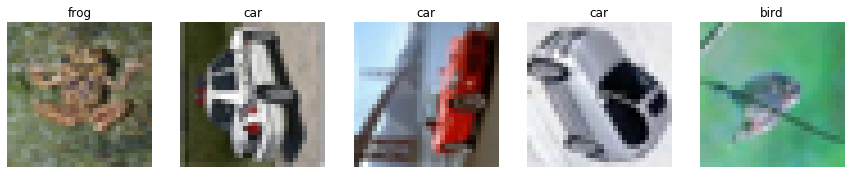

Showing images from test dataset:


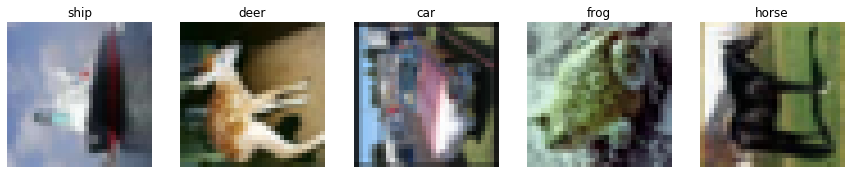

Training Batches #: 391
Testing Batches #: 79
Number of training images: 50,000
Number of test images: 10,000
Image size: 32x32 pixels


In [51]:
# Explore data
## YOUR CODE HERE ##

print("Showing images from train dataset:")
show5_sidebyside(train_loader)

print("Showing images from test dataset:")
show5_sidebyside(test_loader)

print(f'Training Batches #: {len(train_loader)}')
print(f'Testing Batches #: {len(test_loader)}')


# - Print number of training images
input_count = 0
for data in train_loader:
    inputs, labels = data
    input_count += labels.size(0)
 
print("Number of training images: {:,}".format(input_count))

# - Print number of test images
input_count = 0
for data in test_loader:
    inputs, labels = data
    input_count += labels.size(0)
 
print("Number of test images: {:,}".format(input_count))

# - Print size of image(s)
batch = next(iter(train_loader))
image = batch[0][0][0:1]
print('Image size: {}x{} pixels'.format(image.size(1), image.size(2)))



## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [52]:
## YOUR CODE HERE ##
# I have decided to try the LeNet architecture based on recommendations of UdacityGPT and others as a simple but 
# effective architecture for Cifar-10

class LeNet(nn.Module):
    """
    LeNet Class to model the cifar-10 data
    """
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x),dim=1)
        return x
    

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [53]:
## YOUR CODE HERE ##

# Instantiate the model
model = LeNet()

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

model

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [54]:
## YOUR CODE HERE ##

device = 'cpu'

train_loss = []
test_loss = []
test_accuracy = []
epochs = 120

model.to(device)

for epoch in range(epochs):
    model.train()
    training_loss = 0
    testing_loss = 0
    testing_accuracy = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
     
        logps = model.forward(images)
        loss = criterion(logps, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        training_loss += loss.item()
        
    else:
        model.eval()
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)

                logps = model.forward(images)
                loss = criterion(logps, labels)

                ps = torch.exp(logps)
                prob, prob_class = ps.topk(1, dim=1)
                equals = prob_class == labels.view(prob_class.shape)
                accuracy = torch.mean(equals.type(torch.FloatTensor))

                testing_loss += loss.item()
                testing_accuracy += accuracy.item()
    
    train_loss.append(training_loss/len(train_loader))
    test_loss.append(testing_loss/len(test_loader))
    test_accuracy.append(testing_accuracy/len(test_loader))
    
    # print results 
    if epoch % 2 == 0:
        print(f'Epoch: {epoch+1}/{epochs} ...' 
              f'Training Loss: {training_loss/len(train_loader):.04f} ...'
              f'Testing Loss: {testing_loss/len(test_loader):.04f} ...'
              f'Test Accuracy: {testing_accuracy/len(test_loader):.04f}')



Epoch: 1/60 ...Training Loss: 2.1810 ...Testing Loss: 2.1155 ...Test Accuracy: 0.3373
Epoch: 2/60 ...Training Loss: 2.1016 ...Testing Loss: 2.0807 ...Test Accuracy: 0.3774
Epoch: 3/60 ...Training Loss: 2.0694 ...Testing Loss: 2.0787 ...Test Accuracy: 0.3719
Epoch: 4/60 ...Training Loss: 2.0496 ...Testing Loss: 2.0503 ...Test Accuracy: 0.4036
Epoch: 5/60 ...Training Loss: 2.0290 ...Testing Loss: 2.0148 ...Test Accuracy: 0.4417
Epoch: 6/60 ...Training Loss: 2.0130 ...Testing Loss: 2.0132 ...Test Accuracy: 0.4437
Epoch: 7/60 ...Training Loss: 1.9982 ...Testing Loss: 1.9844 ...Test Accuracy: 0.4745
Epoch: 8/60 ...Training Loss: 1.9883 ...Testing Loss: 1.9808 ...Test Accuracy: 0.4784
Epoch: 9/60 ...Training Loss: 1.9755 ...Testing Loss: 1.9799 ...Test Accuracy: 0.4774
Epoch: 10/60 ...Training Loss: 1.9648 ...Testing Loss: 1.9717 ...Test Accuracy: 0.4866
Epoch: 11/60 ...Training Loss: 1.9575 ...Testing Loss: 1.9774 ...Test Accuracy: 0.4800
Epoch: 12/60 ...Training Loss: 1.9483 ...Testing Los

Plot the training loss (and validation loss/accuracy, if recorded).

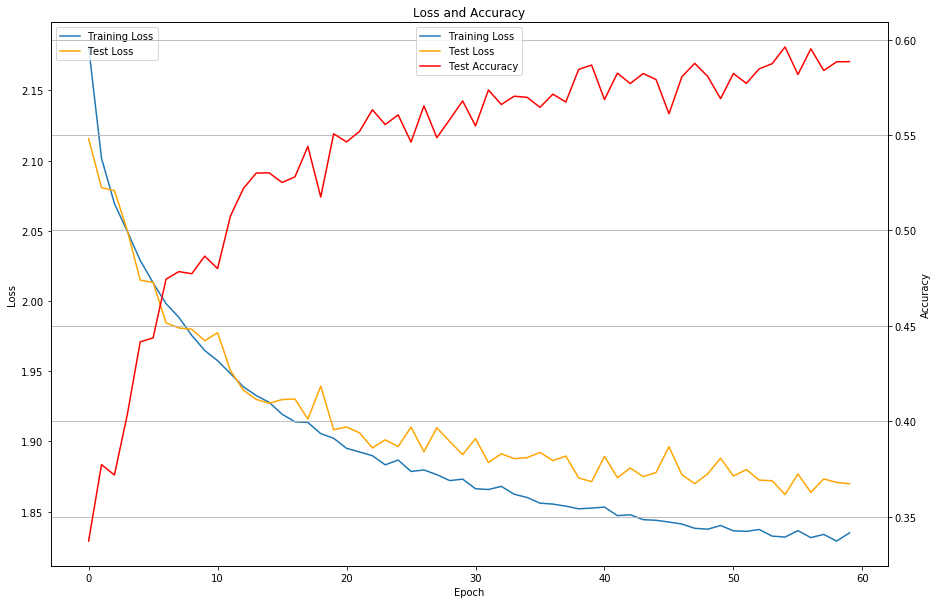

In [55]:

# Plot the train_loss, test_loss and test_accuracy on one chart
plt.figure(figsize=[15, 10])

# Plot Training Loss and Test Loss on the left y-axis
ax1 = plt.subplot(1, 1, 1)
line1, = ax1.plot(train_loss, label='Training Loss')
line2, = ax1.plot(test_loss, color='orange', label='Test Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend(loc='upper left')

# Create a secondary y-axis for Test Accuracy on the right-hand side
ax2 = ax1.twinx()
line3, = ax2.plot(test_accuracy, color='red', label='Test Accuracy')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='upper right')

# Combine legends from both y-axes
lines = [line1, line2, line3]
labels = [line.get_label() for line in lines]
plt.legend(lines, labels, loc='upper center')

plt.title('Loss and Accuracy')
plt.grid(True)
plt.show()


## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [56]:
## YOUR CODE HERE ##

# run the model on the test cases and report the final accuracy
model.eval()
avg_accuracy = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        logps = model.forward(images)
        loss = criterion(logps, labels)

        ps = torch.exp(logps)
        prob, prob_class = ps.topk(1, dim=1)
        equals = prob_class == labels.view(prob_class.shape)
        accuracy = torch.mean(equals.type(torch.FloatTensor))

        avg_accuracy += accuracy.item()

avg_accuracy *= 100
print(f'Model Test Accuracy: {(avg_accuracy/len(test_loader)):.02f}')

Model Test Accuracy: 58.84


## Saving your model
Using `torch.save`, save your model for future loading.

In [57]:
## YOUR CODE HERE ##
torch.save(model.state_dict(), 'cifar10_LeNet_model.pt')

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

The LeNet model is a simple convolutional network model that has demonstrated good results on the cifar-10 dataset.
LeNet accuracy on the cifar-10 dataset has been reported as high as 80.86% by Ho-Phouc et. al. [1]. 

Based on this and other references, I chose and was pleasently surprised at how well the LeNet model worked on a small number of epochs (see above). 

Given this, I would recommend that the company put the cost and effort into an inhouse developmen of a deep learning network

1) Ho-Phuoc, T. (2018). CIFAR10 to Compare Visual Recognition Performance between Deep Neural Networks and Humans. ArXiv, abs/1811.07270.

In [58]:
!!jupyter nbconvert *.ipynb

['[NbConvertApp] Converting notebook CIFAR-10_Image_Classifier.ipynb to html',
 '[NbConvertApp] Writing 395223 bytes to CIFAR-10_Image_Classifier.html']